# Project Overview:

**Goal:** Build an encoder-decoder LSTM model to predict stock prices 30 days ahead using historical data.
**Required Libraries:**

    - Pandas , NumPy, Matplotlib, Seaborn
    - TensorFlow, Keras, Scikit-Learn
    - yFinance, ta-lib

**Dataset Choice: Yahoo Finance API via yfinance**
Why this dataset?

    - Free & accessible
    - Real-world stock data with actual issues (missing values, weekends/holdiays gaps, stock splits)
    - Forces you to handle non-stationarity, noise, and data irregularities
    - Contains OHLCV data needed for technical indicators

First, we're going to collect data. We're going to download 10 years worth of data for multiple stocks, generally the ones in FAANG (AAPL, MSFT, GOOGL, AMZN, TSLA), however for training we're going to focus on one stock initially

In [90]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*10)

data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
    data[ticker] = df
    df.to_csv(f'data/raw_{ticker}.csv')


/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_4989/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_4989/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')

/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_4989/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end= end_date, interval='1d')
[*********************100%***********************]  1 of 1 completed
/var/folders/11/hr72w2z52lg8rt9z9977f9vh0000gn/T/ipykernel_4989/1141164668.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to T

We're going to initially focus on the APPL stock

In [91]:
apple_data = data['AAPL']
apple_data.to_csv('data/raw_AAPL.csv')

Now, we move on to data cleaning and exploration

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Initial inspection

In [93]:
apple_data = pd.read_csv('data/raw_AAPL.csv', skiprows=[1,2], index_col=0, parse_dates=True)
apple_data.index.name = 'Date'
# Flatten the multi-level columns if they exist
if isinstance(apple_data.columns, pd.MultiIndex):
    apple_data.columns = apple_data.columns.get_level_values(0)

print("First 5 rows of the dataset:")
print(apple_data.head())
print("---------------------")
print("Data Info:")
print(apple_data.info())
print("---------------------")
print("Statistical Summary:")
print(apple_data.describe())
print("---------------------")
print(f"\nMissing Values:\n{apple_data.isnull().sum()}")
print("---------------------")
print(f"\nData shape: {apple_data.shape}")
print("---------------------")
print(f"\nDate range:\nFrom {apple_data.index.min()} to {apple_data.index.max()}")

First 5 rows of the dataset:
                Close       High        Low       Open     Volume
Date                                                             
2015-12-02  26.217527  26.630136  26.172434  26.456524  133546400
2015-12-03  25.974014  26.332511  25.753056  26.278399  166278000
2015-12-04  26.837570  26.887174  25.953732  25.994317  231108000
2015-12-07  26.668461  27.024702  26.562490  26.826290  128336800
2015-12-08  26.657194  26.740617  26.348301  26.497110  137238000
---------------------
Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-12-02 to 2025-11-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2513 non-null   float64
 1   High    2513 non-null   float64
 2   Low     2513 non-null   float64
 3   Open    2513 non-null   float64
 4   Volume  2513 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8 KB
None
---------------------
Statistical Su

Checking for missing values to carry on Data cleaning and exploration

In [94]:
print(apple_data.isnull().sum())
apple_data.head()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


,Close,High,Low,Open,Volume
Date,,,,,
2015-12-02,26.217527,26.630136,26.172434,26.456524,133546400
2015-12-03,25.974014,26.332511,25.753056,26.278399,166278000
2015-12-04,26.837570,26.887174,25.953732,25.994317,231108000
2015-12-07,26.668461,27.024702,26.562490,26.826290,128336800
2015-12-08,26.657194,26.740617,26.348301,26.497110,137238000


let's check for outliers now, generally outliers can distort model training, but in stocks, some of these are real events (earnings, splits), therefore we're going to check for extreme outliers in Volume, flag them and do some visualizations

Volume outliers found: 31


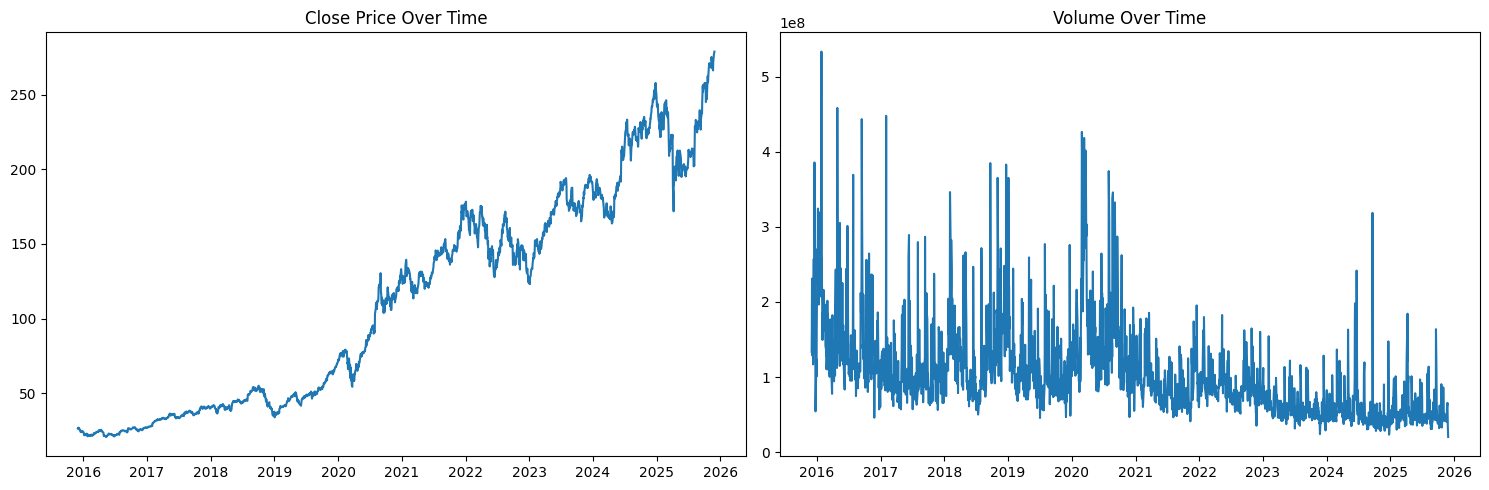

In [95]:
Q1 = apple_data['Volume'].quantile(0.25)
Q3 = apple_data['Volume'].quantile(0.75)
IQR = Q3 - Q1

# flagging outliers, stock splits can cause legitimate spikes in volume
volume_outliers = apple_data[(apple_data['Volume'] < (Q1 - 3 * IQR)) | (apple_data['Volume'] > (Q3 + 3 * IQR))]
print(f"Volume outliers found: {len(volume_outliers)}")

# visualizing to determine if removals are needed
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(apple_data['Close'])
plt.title('Close Price Over Time')
plt.subplot(1,2,2)
plt.plot(apple_data['Volume'])
plt.title('Volume Over Time')
plt.tight_layout()
plt.savefig('plots/01_raw_data_visualiszation.png')
plt.show()

now, let's check for duplicate dates

In [96]:
duplicates = apple_data.index.duplicated().sum()
print(f"Duplicate dates: {duplicates}")

Duplicate dates: 0


Let's now understand volatility, trends, and distribution to help us interpret model predictions.

In [97]:
apple_data['Returns'] = apple_data['Close'].pct_change()
apple_data['Daily_Range'] = apple_data['High'] - apple_data['Low']

print(f"Average daily return: {apple_data['Returns'].mean()*100:.2f}%")
print(f"Return volatility: {apple_data['Returns'].std()*100:.2f}%")
print(f"Average daily range: {apple_data['Daily_Range'].mean():.2f}")


Average daily return: 0.11%
Return volatility: 1.84%
Average daily range: 2.35


Let's do some visualizations for better understanding

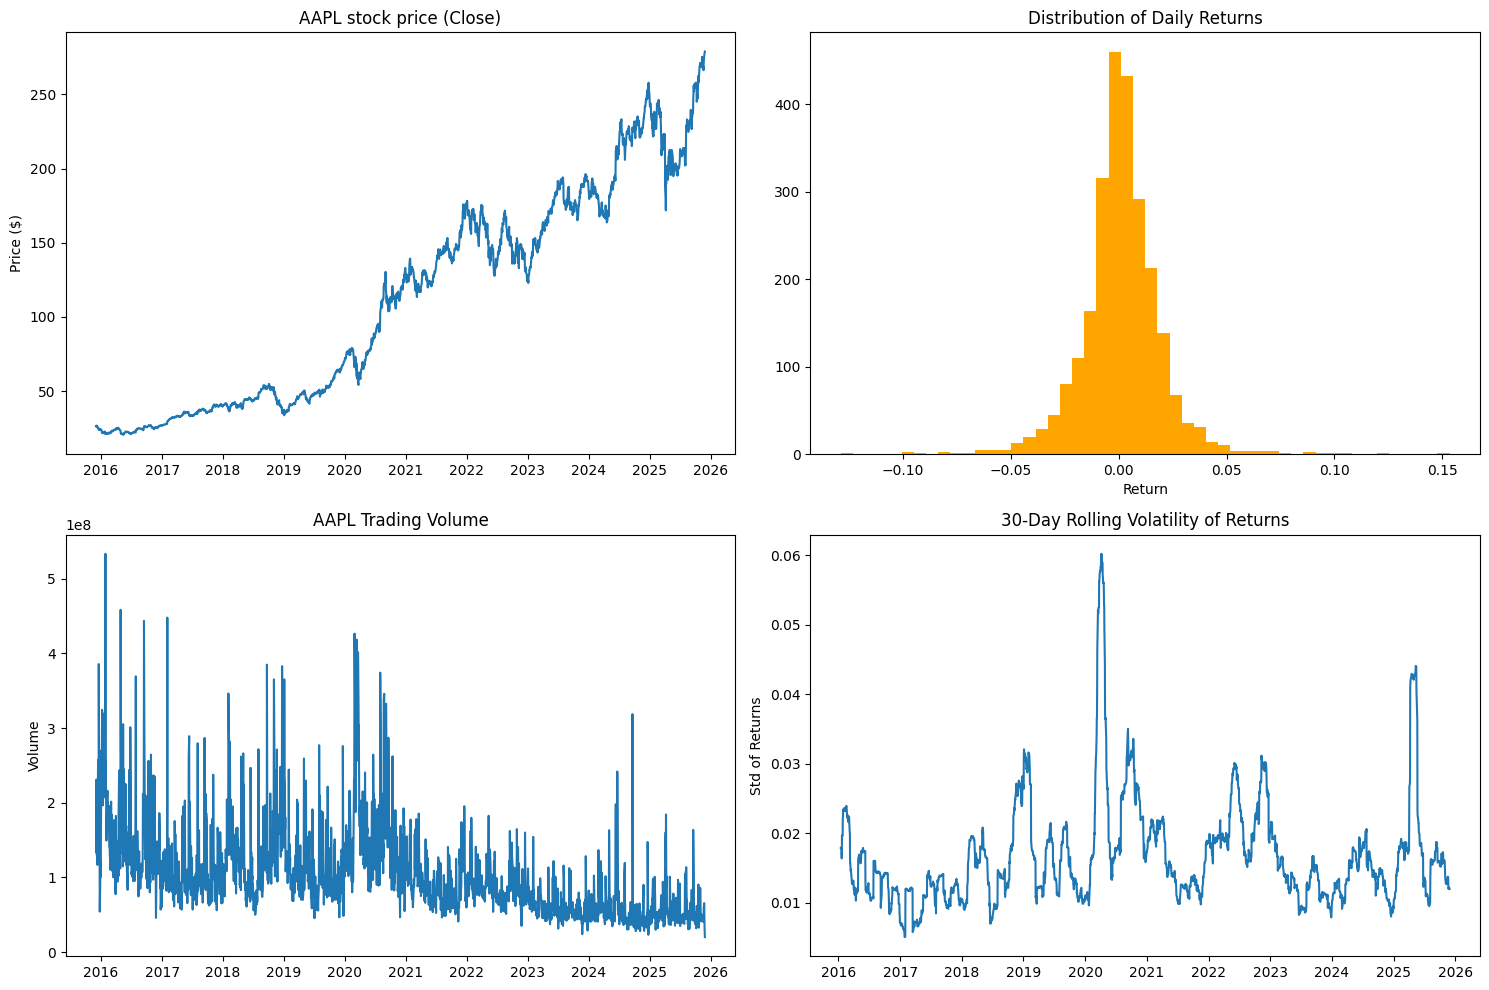

In [98]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
# Price trend
axes[0,0].plot(apple_data['Close'])
axes[0,0].set_title('AAPL stock price (Close)')
axes[0,0].set_ylabel('Price ($)')

# Returns distribution
axes[0,1].hist(apple_data['Returns'].dropna(), bins=50, color='orange')
axes[0,1].set_title('Distribution of Daily Returns')
axes[0,1].set_xlabel('Return')

#Volume
axes[1,0].plot(apple_data['Volume'])
axes[1,0].set_title('AAPL Trading Volume')
axes[1,0].set_ylabel('Volume')

#Price volatility
rolling_std = apple_data['Returns'].rolling(window=30).std()
axes[1,1].plot(rolling_std)
axes[1,1].set_title('30-Day Rolling Volatility of Returns')
axes[1,1].set_ylabel('Std of Returns')

plt.tight_layout()
plt.savefig('plots/02_EDA.png')
plt.show()

To prevent extreme values from dominating (Trading Volume), we're going to cap the trading volume

In [99]:
volume_99th = apple_data['Volume'].quantile(0.99)
apple_data['Volume'] = apple_data['Volume'].clip(upper=volume_99th)

Now, let's move on to feature engineering

Why each indicator:

    - SMA/EMA: Identifying trend direction and support resistance levels
    - MACD: Captures momentum changes and trend reversals
    - RSI: Identify overbought (>70) and oversold (<30) conditions
    - Bollinger Bands: Measures volatility; prices outside bands signal potential reversals
    - ATR: Quantifies market volatility for risk assessment

In [100]:
import ta # technical analysis library
apple_dataFE = apple_data.copy()

# simple moving averages - trend indicators
apple_dataFE['SMA_10'] = apple_dataFE['Close'].rolling(window=10).mean()
apple_dataFE['SMA_50'] = apple_dataFE['Close'].rolling(window=50).mean()
apple_dataFE['SMA_20'] = apple_dataFE['Close'].rolling(window=20).mean()

# Exponential moving averages
apple_dataFE['EMA_12'] = apple_dataFE['Close'].ewm(span=12, adjust=False).mean()
apple_dataFE['EMA_26'] = apple_dataFE['Close'].ewm(span=26, adjust=False).mean()

# MACD
apple_dataFE['MACD'] = apple_dataFE['EMA_12'] - apple_dataFE['EMA_26']
apple_dataFE['MACD_Signal'] = apple_dataFE['MACD'].ewm(span=9, adjust=False).mean()
apple_dataFE['MACD_Hist'] = apple_dataFE['MACD'] - apple_dataFE['MACD_Signal']

# RSI - relative strenght index
delta = apple_dataFE['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
apple_dataFE['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands for volatility
apple_dataFE['BB_Middle'] = apple_dataFE['Close'].rolling(window=20).mean()
bb_std = apple_dataFE['Close'].rolling(window=20).std()
apple_dataFE['BB_Upper'] = apple_dataFE['BB_Middle'] + (2 * bb_std)
apple_dataFE['BB_Lower'] = apple_dataFE['BB_Middle'] - (2 * bb_std)
apple_dataFE['BB_Width'] = apple_dataFE['BB_Upper'] - apple_dataFE['BB_Lower']

# ATR - Average True Range, volatilitymeasure
hig_low = apple_dataFE['High'] - apple_dataFE['Low']
hig_close = np.abs(apple_dataFE['High'] - apple_dataFE['Close'].shift())
low_close = np.abs(apple_dataFE['Low'] - apple_dataFE['Close'].shift())
true_range = pd.concat([hig_low, hig_close, low_close], axis=1).max(axis=1)
apple_dataFE['ATR'] = true_range.rolling(window=14).mean()

print(f"Features created:{apple_dataFE.shape[1]} columns")

Features created:21 columns


Now we're going to create Lag Features, given LSTM learns from sequences, and explicit lag features can boost performance

Lag features is when we explicitly incorporate past values to provide context.

**How Lag Features Improve Model Predictions:**

Tree based models like XGBoost split data into decision nodes based on observed relationships. By adding lag features:

    - The model learns that recent values are predictive
    - If there is a weekly trend, the model recognizes that the value from 7 days ago is an important predictor
    - If a time series exhibits monthly sensionality, the 30-day lag provides critical context.

So basically, without any lag features, a ML model is essentially trying to predict the next frame of a movie for exeample by looking at a single snapshot, rather than understanding the sequence and context.

In [101]:
for lag in [1,2,3,5,7,14,21,30]:
    apple_dataFE[f'Close_lag_{lag}'] = apple_dataFE['Close'].shift(lag)

for lag in [1,7,14]:
    apple_dataFE[f'Volume_lag_{lag}'] = apple_dataFE['Volume'].shift(lag)
    


In [102]:
apple_dataFE.to_csv('data/feature_engineered_AAPL_TEST.csv')

More lags for the Close price lags because price, evidently, has strong temporal dependecies and we're predicting price here, for the volume though, we chose to work ith fewer lags because volume is less predictive and more lags = diminishing returns.

Now we're going to create **Rolling Window Features**.
They capture short-term trends and volatility patterns.
So, **How do Rolling Window Features Improve Model Predictions?**

    - Moving averages help the model recognize if values are increasing or decreasing over time.
    - Rolling standard deviation informs the model about the stability of past values, if recent values have been volatile, predictions should be more cautious.

In [103]:
windows = [7,14,30]
for window in windows:
    apple_dataFE[f"Close_Rolling_Mean_{window}"] = apple_dataFE['Close'].rolling(window=window).mean()
    apple_dataFE[f"Close_Rolling_Std_{window}"] = apple_dataFE['Close'].rolling(window=window).std()
    apple_dataFE[f"Close_Rolling_Min_{window}"] = apple_dataFE['Close'].rolling(window=window).min()
    apple_dataFE[f"Close_Rolling_Max_{window}"] = apple_dataFE['Close'].rolling(window=window).max()
    
apple_dataFE["Momentum_7"] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_7']
apple_dataFE['Momentum_14'] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_14']
apple_dataFE['Momentum_30'] = apple_dataFE['Close'] - apple_dataFE['Close_Rolling_Mean_30']

print(f"After rolling features: {apple_dataFE.shape[1]} columns")

After rolling features: 47 columns


Now, to not keep things cluttered, we're going to need to clean up and prepare the final feature set

In [104]:
apple_dataFE = apple_dataFE.dropna()

feature_columns = ['Close', 'Volume','High',
                   'Low','SMA_10','SMA_20','SMA_50',
                   'EMA_12','EMA_26','MACD','MACD_Signal',
                   'RSI','BB_Upper','BB_Lower','BB_Width',
                   'ATR', 'Close_lag_1', 'Close_lag_7', 'Close_lag_30',
                   'Close_Rolling_Mean_7', 'Close_Rolling_Std_7',
                   'Close_Rolling_Mean_14', 'Close_Rolling_Std_14',
                   'Close_Rolling_Mean_30', 'Close_Rolling_Std_30',
                   'Momentum_7',
                   'Momentum_30']

apple_final = apple_dataFE[feature_columns].copy()
print(f"Final feature set shape: {apple_final.shape}")
print(f"Features:\n{apple_final.columns.tolist()}")
apple_final.to_csv('data/featured_AAPL.csv')
print(apple_final.head())

Final feature set shape: (2464, 27)
Features:
['Close', 'Volume', 'High', 'Low', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI', 'BB_Upper', 'BB_Lower', 'BB_Width', 'ATR', 'Close_lag_1', 'Close_lag_7', 'Close_lag_30', 'Close_Rolling_Mean_7', 'Close_Rolling_Std_7', 'Close_Rolling_Mean_14', 'Close_Rolling_Std_14', 'Close_Rolling_Mean_30', 'Close_Rolling_Std_30', 'Momentum_7', 'Momentum_30']
                Close       Volume       High        Low     SMA_10  \
Date                                                                  
2016-02-12  21.306818  161405600.0  21.422432  21.084660  21.497005   
2016-02-16  21.907551  196231600.0  21.955156  21.447366  21.513562   
2016-02-17  22.243057  179452800.0  22.263459  21.796473  21.607637   
2016-02-18  21.821411  156084000.0  22.417612  21.782872  21.617385   
2016-02-19  21.771542  141496800.0  21.934760  21.717136  21.604691   

               SMA_20     SMA_50     EMA_12     EMA_26      MACD  ...  \
Date 

Onto the next phase: Data Preprocessing for LSTM

First we're going to start with train-validation-test split, and for that we're going to use chronological split for time series, never a random split. (very critical) The reason is that stock prediction is about forecasting future unseen data, not random patterns.

In [105]:
from sklearn.preprocessing import MinMaxScaler

We're going to now load the featured data

In [106]:
df = pd.read_csv('data/featured_AAPL.csv', index_col=0, parse_dates=True)

Now, let's move to the chronological split, 70% train, 15% validation, 15% test

In [107]:
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
train_data = df[:train_size]
val_data = df[train_size:train_size+val_size]
test_data = df[train_size+val_size:]

let's visualize some of these new dataframes

In [108]:
print(f"Train: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
print(f"Val: {len(val_data)} samples ({val_data.index.min()} to {val_data.index.max()})")
print(f"Test: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")

Train: 1724 samples (2016-02-12 00:00:00 to 2022-12-15 00:00:00)
Val: 369 samples (2022-12-16 00:00:00 to 2024-06-06 00:00:00)
Test: 371 samples (2024-06-07 00:00:00 to 2025-11-28 00:00:00)


now, we need to normalize the data.
fit scaler only on training data, then transform all sets.
The scaler is fit only on the training data to avoid leakage: this ensures that the transformation computes its stats (min,max, or mean) only from data the model is allowed to see during training, no from data in the validation or test sets that will be used for model selection or final eval

In [109]:
feature_scaler = MinMaxScaler(feature_range=(0,1))
close_scaler = MinMaxScaler(feature_range=(0,1))
feature_scaler.fit(train_data)
close_scaler.fit(train_data[['Close']])
train_scaled = feature_scaler.transform(train_data)
val_scaled = feature_scaler.transform(val_data)
test_scaled = feature_scaler.transform(test_data)

we used MinMaxScaler because LSTM works best with values in range; prevents gradient issues

now let's do some checks

In [110]:
print(f"\n✓ Features scaled")
print(f"Train range: [{train_scaled.min():.3f}, {train_scaled.max():.3f}]")
print(f"Val range: [{val_scaled.min():.3f}, {val_scaled.max():.3f}]")
print(f"Test range: [{test_scaled.min():.3f}, {test_scaled.max():.3f}]")


✓ Features scaled
Train range: [0.000, 1.000]
Val range: [-0.039, 1.148]
Test range: [-0.801, 2.680]


now let's save the scaler for inverse transform

In [111]:
import joblib
joblib.dump(feature_scaler, 'models/feature_scaler.pkl')
joblib.dump(close_scaler, 'models/close_scaler.pkl')

['models/close_scaler.pkl']

Now, let's move on to creating sequences for encoder-decoder

**Why's this crucial?** because we need sequences of past 60 days to predict the next 30 days

In [112]:
def create_encoder_decoder_sequences(data, close_column_data, n_input_steps=60, n_output_steps=30):
    X, y = [], []
    for i in range(len(data)-n_input_steps-n_output_steps):
        X.append(data[i:i+n_input_steps,:])
        y.append(close_column_data[i+n_input_steps:i+n_input_steps+n_output_steps,0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [113]:
train_close_scaled = close_scaler.transform(train_data[['Close']])
val_close_scaled = close_scaler.transform(val_data[['Close']])
test_close_scaled = close_scaler.transform(test_data[['Close']])

In [114]:
input_steps, output_steps = 60, 30
X_train, y_train = create_encoder_decoder_sequences(train_scaled,train_close_scaled,input_steps,output_steps)
X_val, y_val = create_encoder_decoder_sequences(val_scaled,val_close_scaled,input_steps,output_steps)
X_test, y_test = create_encoder_decoder_sequences(test_scaled,test_close_scaled,input_steps,output_steps)

let's check some of that data, and save it

In [115]:
print(f"Sequences created")
print(f"X_train: {X_train.shape}, range: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"y_train: {y_train.shape}, range: [{y_train.min():.3f}, {y_train.max():.3f}]")

# Verify targets are in correct range
assert 0 <= y_train.min() <= 1 and 0 <= y_train.max() <= 1, "Targets not in [0,1]!"
print("\nData validation passed!")


np.save('data/X_train.npy', X_train) 
np.save('data/y_train.npy', y_train)
np.save('data/X_val.npy', X_val)
np.save('data/y_val.npy', y_val)
np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)

Sequences created
X_train: (1634, 60, 27), range: [0.000, 1.000]
y_train: (1634, 30), range: [0.000, 1.000]

Data validation passed!


Now let's build encoder-decoder lstm model

In [116]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

now let's load the prepared data

In [117]:
X_train = np.load('data/X_train.npy')
y_train = np.load('data/y_train.npy')
X_val = np.load('data/X_val.npy')
y_val = np.load('data/y_val.npy')

n_input_steps = 60
n_output_steps = 30
n_features = X_train.shape[2]


print(f"Building encoder-decoder lstm model for:")
print(f"  Input: {n_input_steps} timesteps, {n_features} features")
print(f"  Output: {n_output_steps} timesteps, 1 feature (Close price)")

Building encoder-decoder lstm model for:
  Input: 60 timesteps, 27 features
  Output: 30 timesteps, 1 feature (Close price)


encoder part

In [118]:
encoder_inputs = Input(shape=(n_input_steps,n_features), name='encoder_input')
encoder_lstm1 = LSTM(100, return_sequences=True, return_state=False,name='encoder_lstm1')(encoder_inputs)
encoder_dropout1 = Dropout(0.2, name='encoder_dropout1')(encoder_lstm1)

encoder_lstm2 = LSTM(100,return_sequences=False, return_state=True,name='encoder_lstm2')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_dropout1)

encoder_states = [state_h, state_c]

decoder part

In [119]:
decoder_inputs = RepeatVector(n_output_steps, name='repeat_vector')(state_h)

decoder_lstm1 = LSTM(100, return_sequences=True, return_state=False, name='decoder_lstm1')
decoder_outputs1 = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_dropout1 = Dropout(0.2, name='decoder_dropout1')(decoder_outputs1)

decoder_lstm2 = LSTM(100, return_sequences=True, return_state=False, name='decoder_lstm2')(decoder_dropout1)
decoder_dropout2 = Dropout(0.2, name='decoder_dropout2')(decoder_lstm2)
decoder_dense = TimeDistributed(Dense(50, activation='relu'), name='decoder_dense1')(decoder_dropout2)
decoder_outputs = TimeDistributed(Dense(1), name='decoder_output')(decoder_dense)


the actual model

In [120]:
model = Model(encoder_inputs, decoder_outputs, name='encoder_decoder_lstm')

now lets compile with appropriate loss

In [121]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "encoder_decoder_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 60, 27)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ (None, 60, 100)   │     51,200 │ encoder_input[0]… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dropout1    │ (None, 60, 100)   │          0 │ encoder_lstm1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ [(None, 100),     │     80,400 │ encoder_dropout1… │
│ (LSTM)              │ (None, 100),      │            │                   │
│                     │ (None, 100)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 30, 100)   │          0 │ encoder_lstm2[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm1       │ (None, 30, 100)   │     80,400 │ repeat_vector[0]… │
│ (LSTM)              │                   │            │ encoder_lstm2[0]… │
│                     │                   │            │ encoder_lstm2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout1    │ (None, 30, 100)   │          0 │ decoder_lstm1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm2       │ (None, 30, 100)   │     80,400 │ decoder_dropout1… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dropout2    │ (None, 30, 100)   │          0 │ decoder_lstm2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense1      │ (None, 30, 50)    │      5,050 │ decoder_dropout2… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_output      │ (None, 30, 1)     │         51 │ decoder_dense1[0… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 297,501 (1.13 MB)

 Trainable params: 297,501 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

now let's save the model architecture diagram

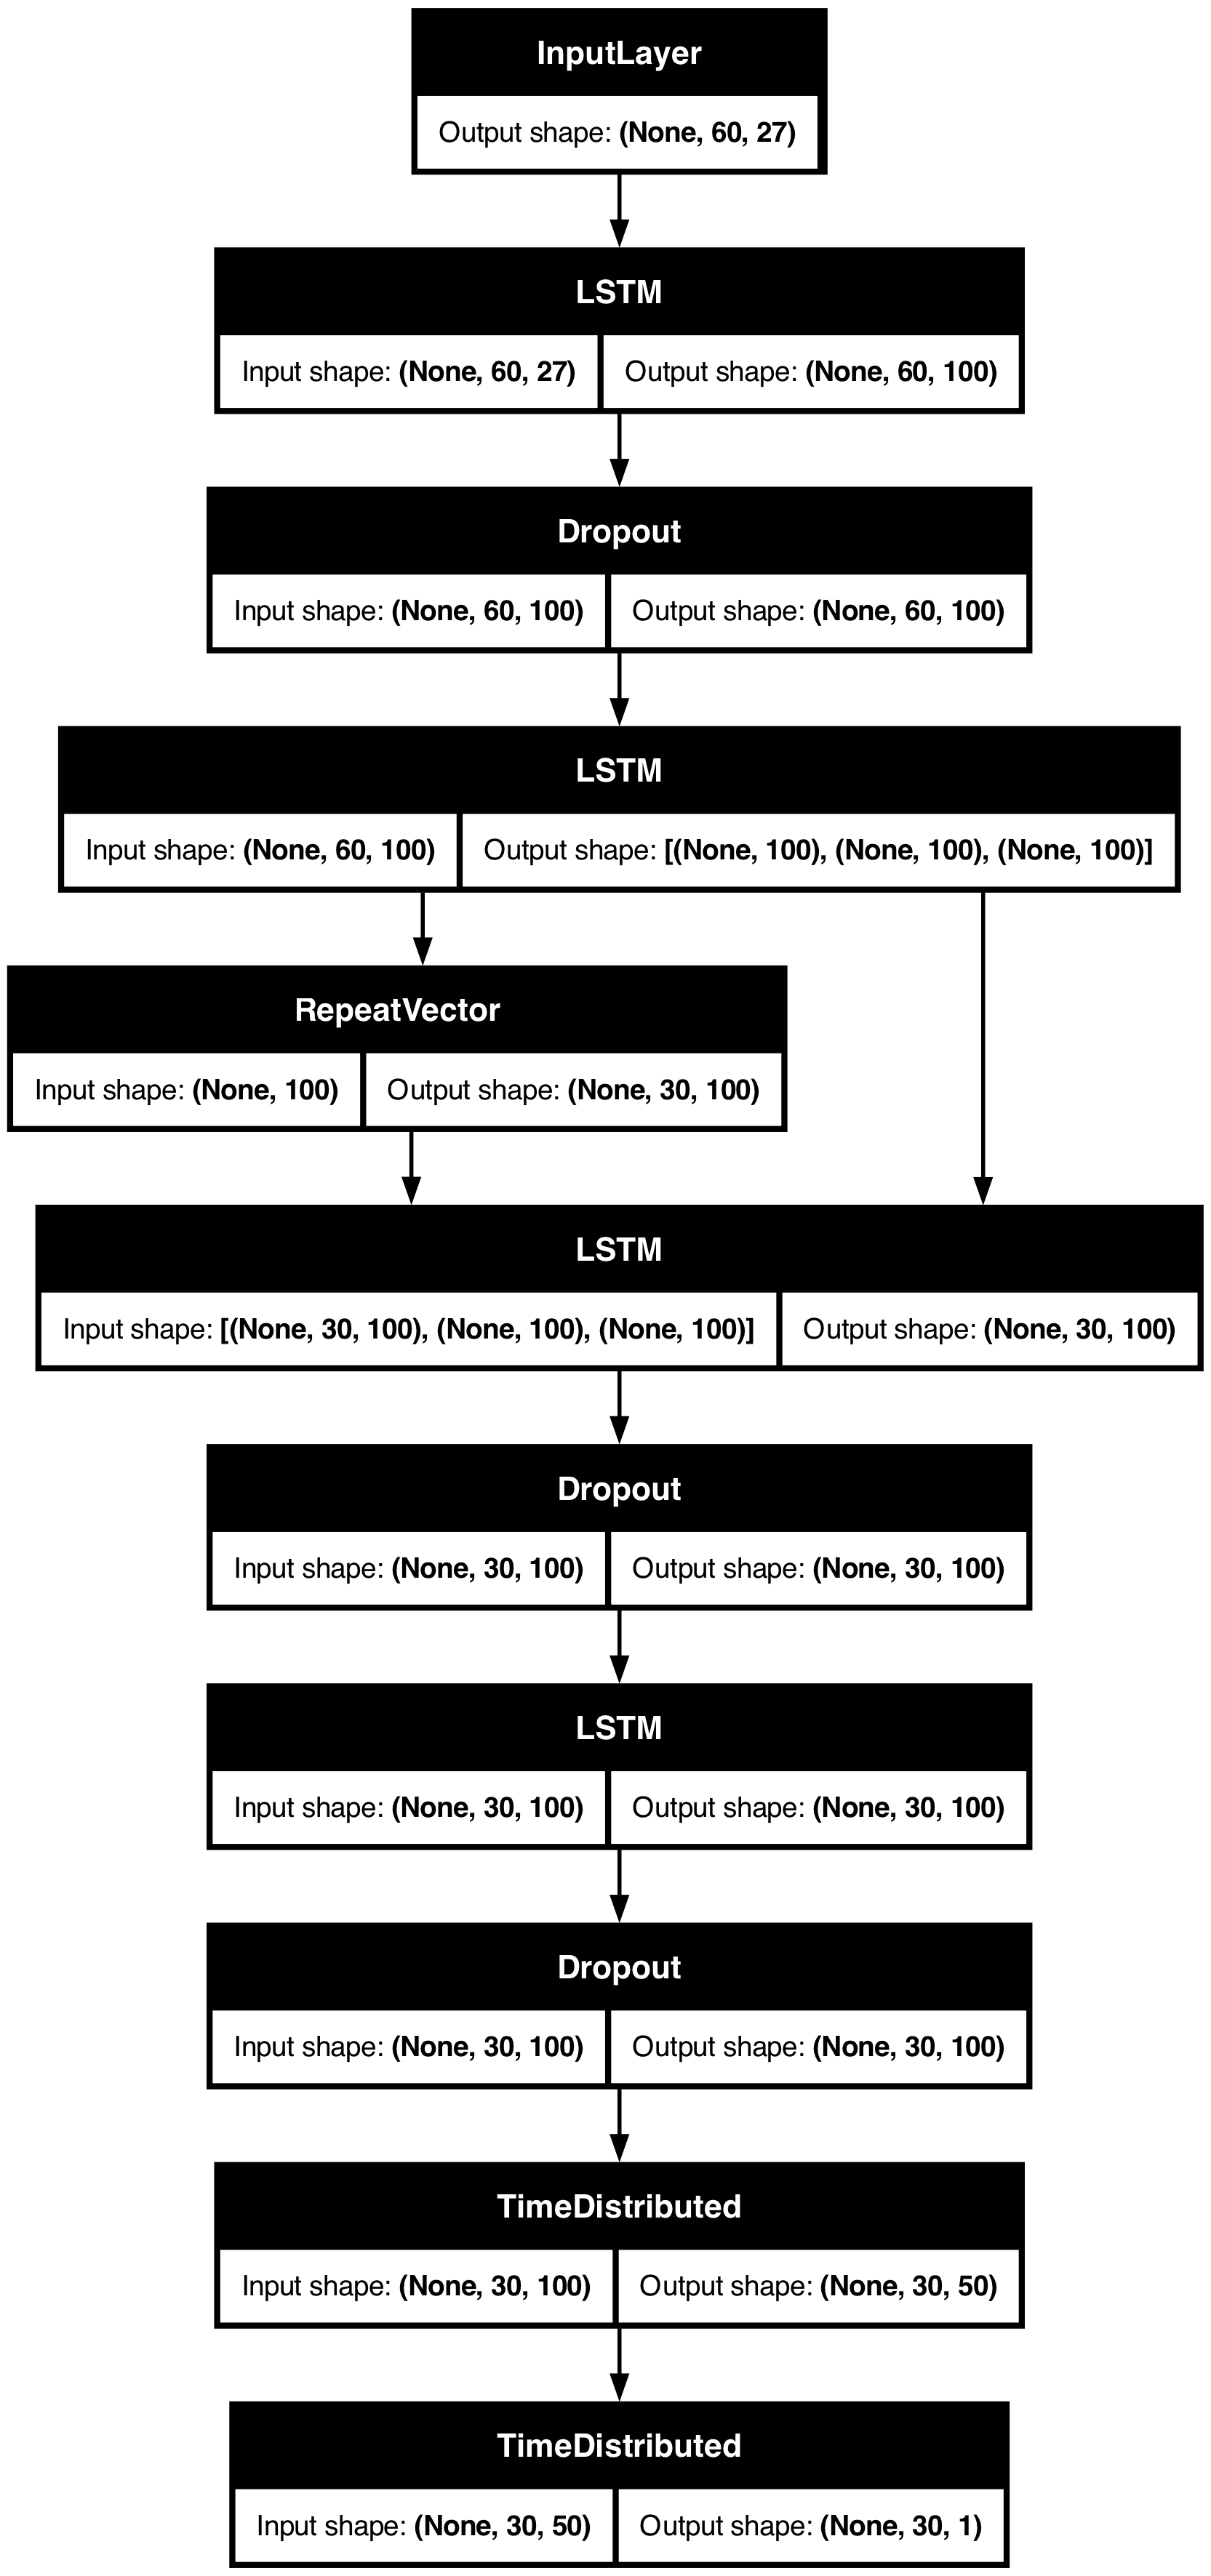

In [122]:
tf.keras.utils.plot_model(model, to_file='plots/model_architecture.png', show_shapes=True)

**Why this architecture?**

    - 2-layer encoder : to capture complex temporal patterns in 60-days sequences
    - Dropout (0,2): to prevent overfitting to training data
    - RepeatVector: broadcasts encoder context to all decoder timesteps
    - 2-layer decoder: to generate 30-day predictions from context
    - TimeDistributed Dense: to aply same transformation to each output timestep

Now, let's train the model. We're going to first define callbacks, then train the model and finally save the final model and training history

In [123]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

model.save('models/final_model.keras')
np.save('models/training_history.npy', history.history)

Epoch 1/200
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0750 - mae: 0.1634
Epoch 1: val_loss improved from None to 0.01960, saving model to models/best_model.keras

Epoch 1: val_loss improved from None to 0.01960, saving model to models/best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0269 - mae: 0.0909 - val_loss: 0.0196 - val_mae: 0.1202 - learning_rate: 0.0010
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 0.0269 - mae: 0.0909 - val_loss: 0.0196 - val_mae: 0.1202 - learning_rate: 0.0010
Epoch 2/200
51/52 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0057 - mae: 0.0498
Epoch 2: val_loss improved from 0.01960 to 0.01115, saving model to models/best_model.keras

Epoch 2: val_loss improved from 0.01960 to 0.01115, saving model to models/best_model.keras
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0051 - mae: 0.0474 - val_loss: 0.0112 - val_mae: 0.0910 - learning_rate: 0.0010
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0051 - m

**Why these callbacks?**

    - EarlyStopping: stops if validation loss doesn't improve for 20 epochs to prevent overfitting
    - ModelCheckpoint: Saves best model during training (recovers best version)
    - ReduceLROnPlateau: decreases the learning rate when stuck to help convergence

Now, let's visualize the training progress

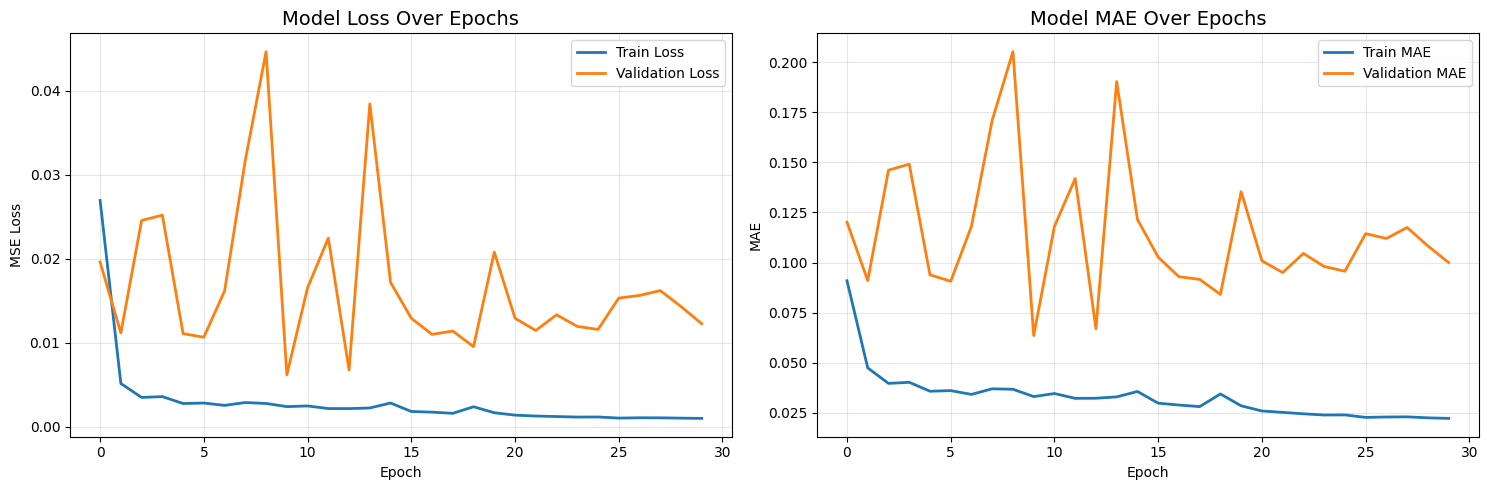

Best validation loss: 0.006162
Best validation MAE: 0.063561


In [124]:
history_dict = np.load('models/training_history.npy', allow_pickle=True).item()

fig, axes = plt.subplots(1,2,figsize=(15,5))

#loss
axes[0].plot(history_dict['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_dict['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss Over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#mae
axes[1].plot(history_dict['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history_dict['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Model MAE Over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/03_training_curves.png', dpi=300)
plt.show()

print(f"Best validation loss: {min(history_dict['val_loss']):.6f}")
print(f"Best validation MAE: {min(history_dict['val_mae']):.6f}")

#### Evaluation & Analysis

Let's generate predictions

In [125]:
model = keras.models.load_model('models/best_model.keras')
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')
predictions = model.predict(X_test, verbose=1)

# some checks
print(f"Predictions shape: {predictions.shape}")
print(f"Actual shape: {y_test.shape}")

np.save('results/predictions.npy', predictions)
np.save('results/actuals.npy', y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
Predictions shape: (281, 30, 1)
Actual shape: (281, 30)
Predictions shape: (281, 30, 1)
Actual shape: (281, 30)


Inverse Transform to original scale

In [126]:
scaler = joblib.load('models/scaler.pkl')

def inverse_transform_predictions(predictions, scaler, n_features):
    n_samples, n_steps, _ = predictions.shape
    # create a dummy array with all features
    dummy = np.zeros((n_samples * n_steps, n_features))
    dummy[:,0] = predictions.reshape(-1)  # assuming 'Close' is the first feature
    inverse = scaler.inverse_transform(dummy)
    prices = inverse[:,0].reshape(n_samples, n_steps)
    return prices

n_features = 27
predictions_original = inverse_transform_predictions(predictions, scaler, n_features)
# Reshape y_test from (samples, steps) to (samples, steps, 1) to match predictions shape
actuals_original = inverse_transform_predictions(y_test.reshape(y_test.shape[0], y_test.shape[1], 1), scaler, n_features)

# checks
print(f"Predictions original shape: {predictions_original.shape}")
print(f"Sample prediction (30 days): {predictions_original[0]}")
print(f"Sample actual (30 days): {actuals_original[0]}")

np.save('results/predictions_original.npy', predictions_original)
np.save('results/actuals_original.npy', actuals_original)

Predictions original shape: (281, 30)
Sample prediction (30 days): [188.22757847 175.86743638 178.34650551 177.39709018 176.5139094
 175.62389655 174.84664597 174.22352608 173.70433469 173.28326405
 172.94831338 172.68406115 172.47596922 172.31177366 172.18172912
 172.0783081  171.99585321 171.93004154 171.87755572 171.83575502
 171.80260955 171.77639953 171.75579051 171.73966416 171.72711831
 171.71740115 171.70994882 171.70425385 171.69992154 171.69666995]
Sample actual (30 days): [219.61404269 221.13546597 219.5841965  219.67370455 218.87817235
 221.41390835 221.5232986  221.2547897  215.10938892 215.5767351
 219.45490878 227.5891248  226.92289557 225.20257398 226.0975477
 225.10313246 226.24670236 226.51518074 231.69601247 224.94402907
 225.51081677 224.40704178 225.53074474 220.44935455 224.50649857
 228.2553998  227.75817691 226.27653329 230.00555232 232.54127305]


let's calculate metrics

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics_per_day = {
    'Day': [],
    'MAE': [],
    'RMSE': [],
    'MAPE': [],
    'R2': []
}

for day in range(30):
    day_predictions = predictions_original[:, day]
    day_actuals = actuals_original[:, day]
    
    mae = mean_absolute_error(day_actuals, day_predictions)
    rmse = np.sqrt(mean_squared_error(day_actuals, day_predictions))
    mape = np.mean(np.abs((day_actuals - day_predictions) / day_actuals)) * 100
    r2 = r2_score(day_actuals, day_predictions)
    
    metrics_per_day['Day'].append(day + 1)
    metrics_per_day['MAE'].append(mae)
    metrics_per_day['RMSE'].append(rmse)
    metrics_per_day['MAPE'].append(mape)
    metrics_per_day['R2'].append(r2)
    
metrics_df = pd.DataFrame(metrics_per_day)
metrics_df.to_csv('results/per_day_metrics.csv', index=False)
print(metrics_df)

    Day        MAE       RMSE       MAPE        R2
0     1  38.331725  40.579892  16.742166 -4.486553
1     2  50.217807  52.247977  22.014482 -8.015996
2     3  48.046255  50.171979  21.029136 -7.179930
3     4  49.117529  51.280677  21.483324 -7.408707
4     5  50.075005  52.273933  21.887207 -7.630756
5     6  51.072591  53.304153  22.308153 -7.860333
6     7  51.961590  54.221176  22.680933 -8.028568
7     8  52.768704  55.068890  23.013152 -8.127547
8     9  53.454209  55.796043  23.290950 -8.187308
9    10  54.061998  56.443725  23.531732 -8.226387
10   11  54.588180  57.014811  23.734982 -8.228536
11   12  55.027304  57.499465  23.901313 -8.209020
12   13  55.377397  57.895066  24.031922 -8.171139
13   14  55.690297  58.254835  24.145137 -8.117736
14   15  55.976081  58.586064  24.245718 -8.058599
15   16  56.231092  58.884634  24.333389 -7.995772
16   17  56.464406  59.156890  24.412155 -7.937698
17   18  56.681615  59.415172  24.483403 -7.870312
18   19  56.905509  59.693335  

let's visualize predictions

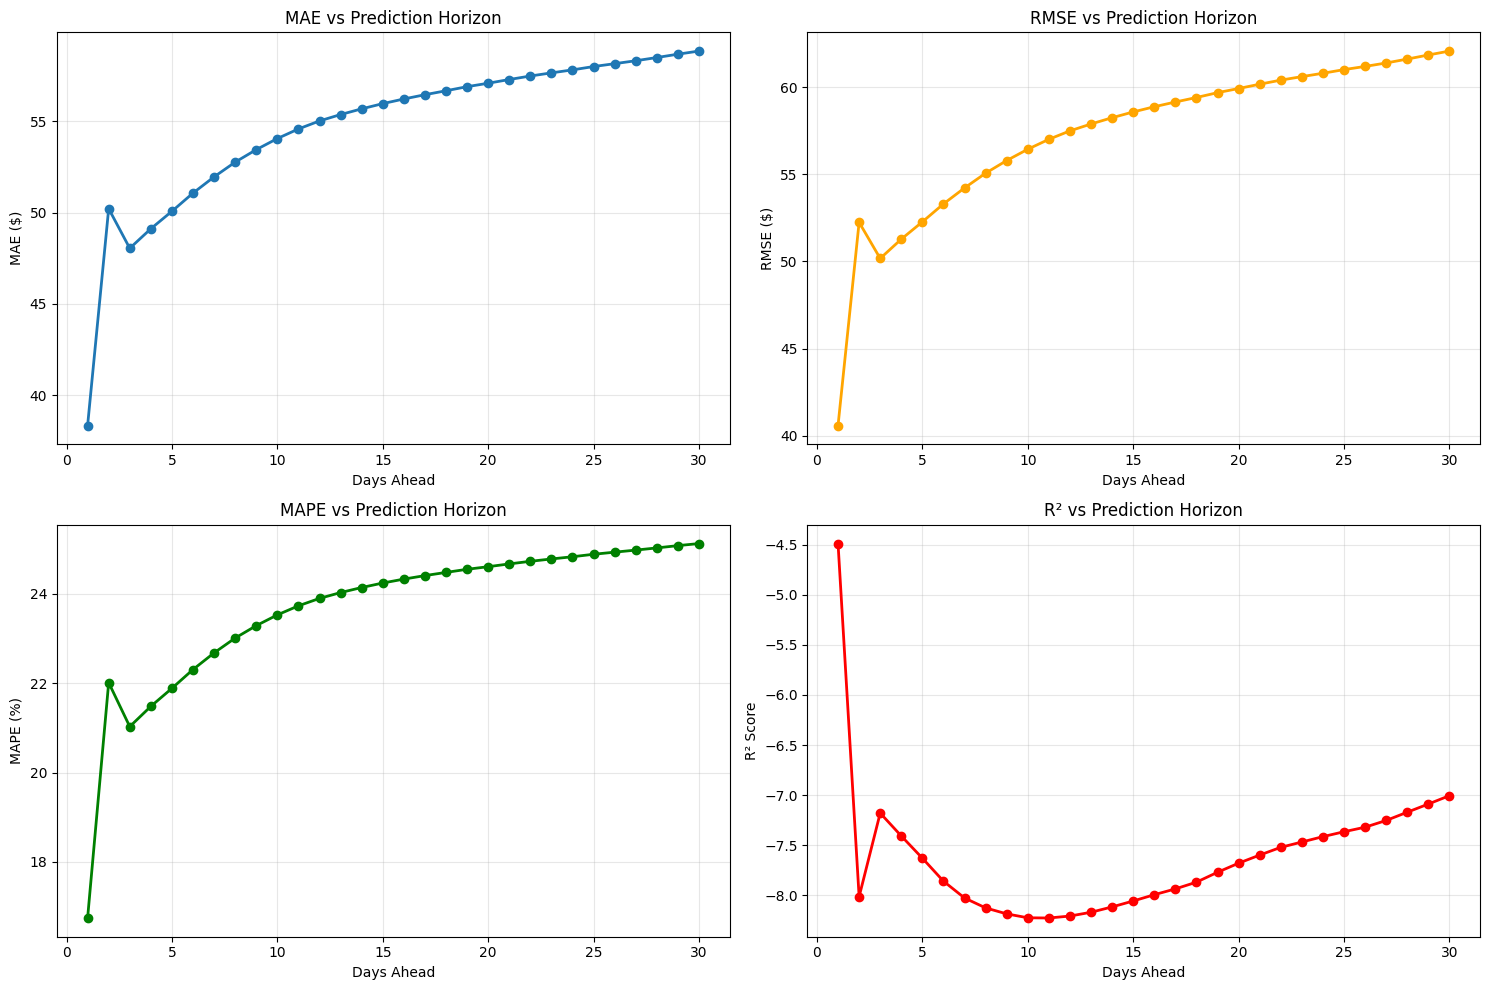

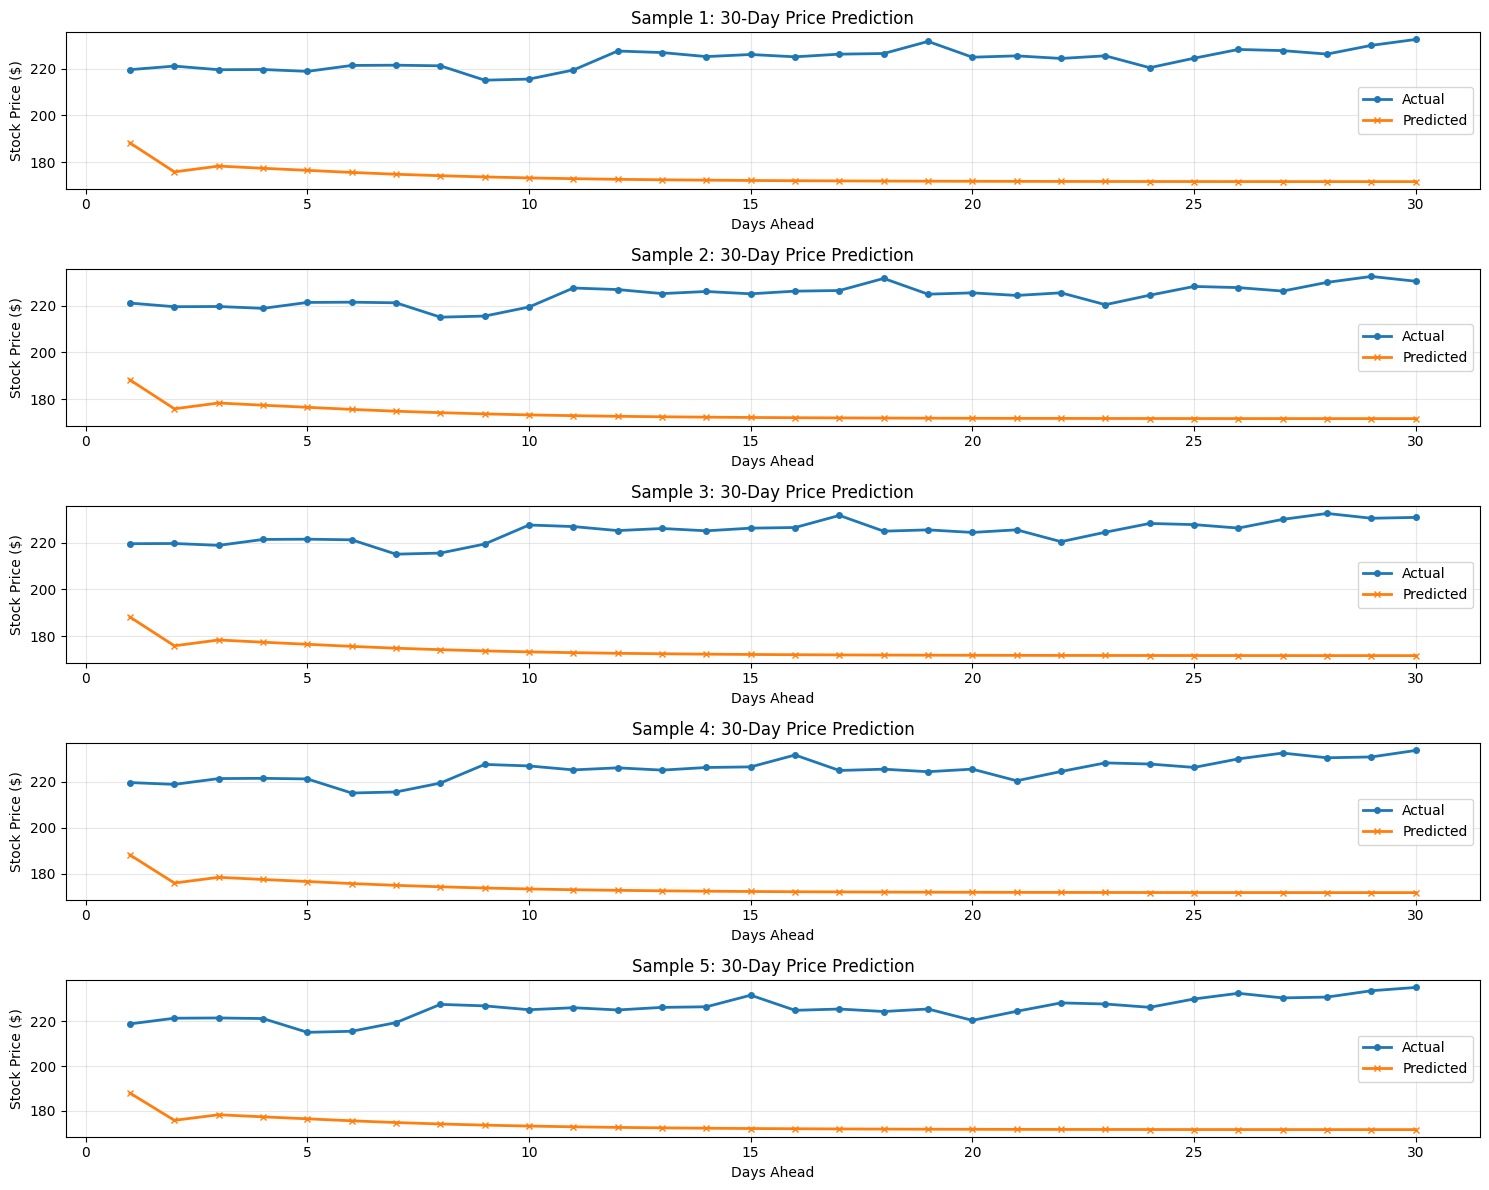

In [128]:
# Plot metrics degradation over horizon
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(metrics_df['Day'], metrics_df['MAE'], marker='o', linewidth=2)
axes[0, 0].set_title('MAE vs Prediction Horizon')
axes[0, 0].set_xlabel('Days Ahead')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(metrics_df['Day'], metrics_df['RMSE'], marker='o', linewidth=2, color='orange')
axes[0, 1].set_title('RMSE vs Prediction Horizon')
axes[0, 1].set_xlabel('Days Ahead')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(metrics_df['Day'], metrics_df['MAPE'], marker='o', linewidth=2, color='green')
axes[1, 0].set_title('MAPE vs Prediction Horizon')
axes[1, 0].set_xlabel('Days Ahead')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(metrics_df['Day'], metrics_df['R2'], marker='o', linewidth=2, color='red')
axes[1, 1].set_title('R² vs Prediction Horizon')
axes[1, 1].set_xlabel('Days Ahead')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/04_metrics_vs_horizon.png', dpi=300)
plt.show()

# Plot sample predictions
n_samples_to_plot = 5

fig, axes = plt.subplots(n_samples_to_plot, 1, figsize=(15, 12))

for i in range(n_samples_to_plot):
    axes[i].plot(range(1, 31), actuals_original[i], 
                 label='Actual', marker='o', linewidth=2, markersize=4)
    axes[i].plot(range(1, 31), predictions_original[i], 
                 label='Predicted', marker='x', linewidth=2, markersize=4)
    axes[i].set_title(f'Sample {i+1}: 30-Day Price Prediction')
    axes[i].set_xlabel('Days Ahead')
    axes[i].set_ylabel('Stock Price ($)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/05_sample_predictions.png', dpi=300)
plt.show()
